In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline

# Function definitions

In [6]:
def reduce_memory(df):
    """
    Reduces memory footprint of the input dataframe.
    Changes float64 columns to float32 dtype.
    """
    columns = df.columns
    memory_before = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB

    for column in tqdm(columns):
        if df[column].dtype == 'float64':
            df[column] = df[column].astype('float32')
        
    memory_after = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB
    print('Memory uasge reduced from %.3f GB to %.3f GB' % (memory_before, memory_after))
    
    return df


def create_corr_matrix(df, dwelling_id, annot):
    """
    Pearson correlation coefficient matrix. 
    The Pearson correlation coefficient is a measure of the linear correlation between two variables.
    """
    plt.clf()
    
    corr = df.corr()
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True

    if annot:
        fig, ax = plt.subplots(figsize=(25,25))
    else:
        fig, ax = plt.subplots()

    fig = sns.heatmap(corr, mask=mask, square=False, cmap='RdYlGn', annot=annot, ax=ax, 
                cbar_kws={'label':'Pearson correlation coefficient [-]'})

    fig.set_title('Correlation matrix of dwelling ID: '+dwelling_id)
    fig.tick_params(axis='x', rotation=90)
    fig.tick_params(axis='y', rotation=0)

    fig = fig.get_figure()
    fig.tight_layout()
    fig.show()
    
    print('Saving heatmap')
    #fig.savefig('//datc//opschaler//EDA//Pearson_corr//' + dwelling_id + '.png', dpi=300)
    return fig

# Reading in data

In [7]:
%%time
df_10s = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//all_dwellings_combined_10s.csv', delimiter='\t', parse_dates=['datetime'])
#df_10s = df_10s.set_index(['datetime'])

CPU times: user 1min 42s, sys: 14.9 s, total: 1min 57s
Wall time: 1min 58s


In [8]:
df = reduce_memory(df_10s)

100%|██████████| 25/25 [00:47<00:00,  1.88s/it]

Memory uasge reduced from 6.478 GB to 3.498 GB


In [9]:
df.columns

Index(['datetime', 'eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn',
       'ePower', 'ePowerReturn', 'gasMeter', 'gasPower', 'DD', 'DR', 'FF',
       'FX', 'N', 'P', 'Q', 'RG', 'SQ', 'T', 'T10', 'TD', 'U', 'VV', 'WW',
       'dwelling'],
      dtype='object')

In [10]:
t = df.set_index(['datetime'])

# EDA on daily mean data

In [11]:
%%time
day = t.resample('24H').mean()
day = day.dropna()

CPU times: user 10.3 s, sys: 7.98 s, total: 18.3 s
Wall time: 18.3 s


Saving heatmap
CPU times: user 148 ms, sys: 57.6 ms, total: 205 ms
Wall time: 212 ms


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 432x288 with 0 Axes>

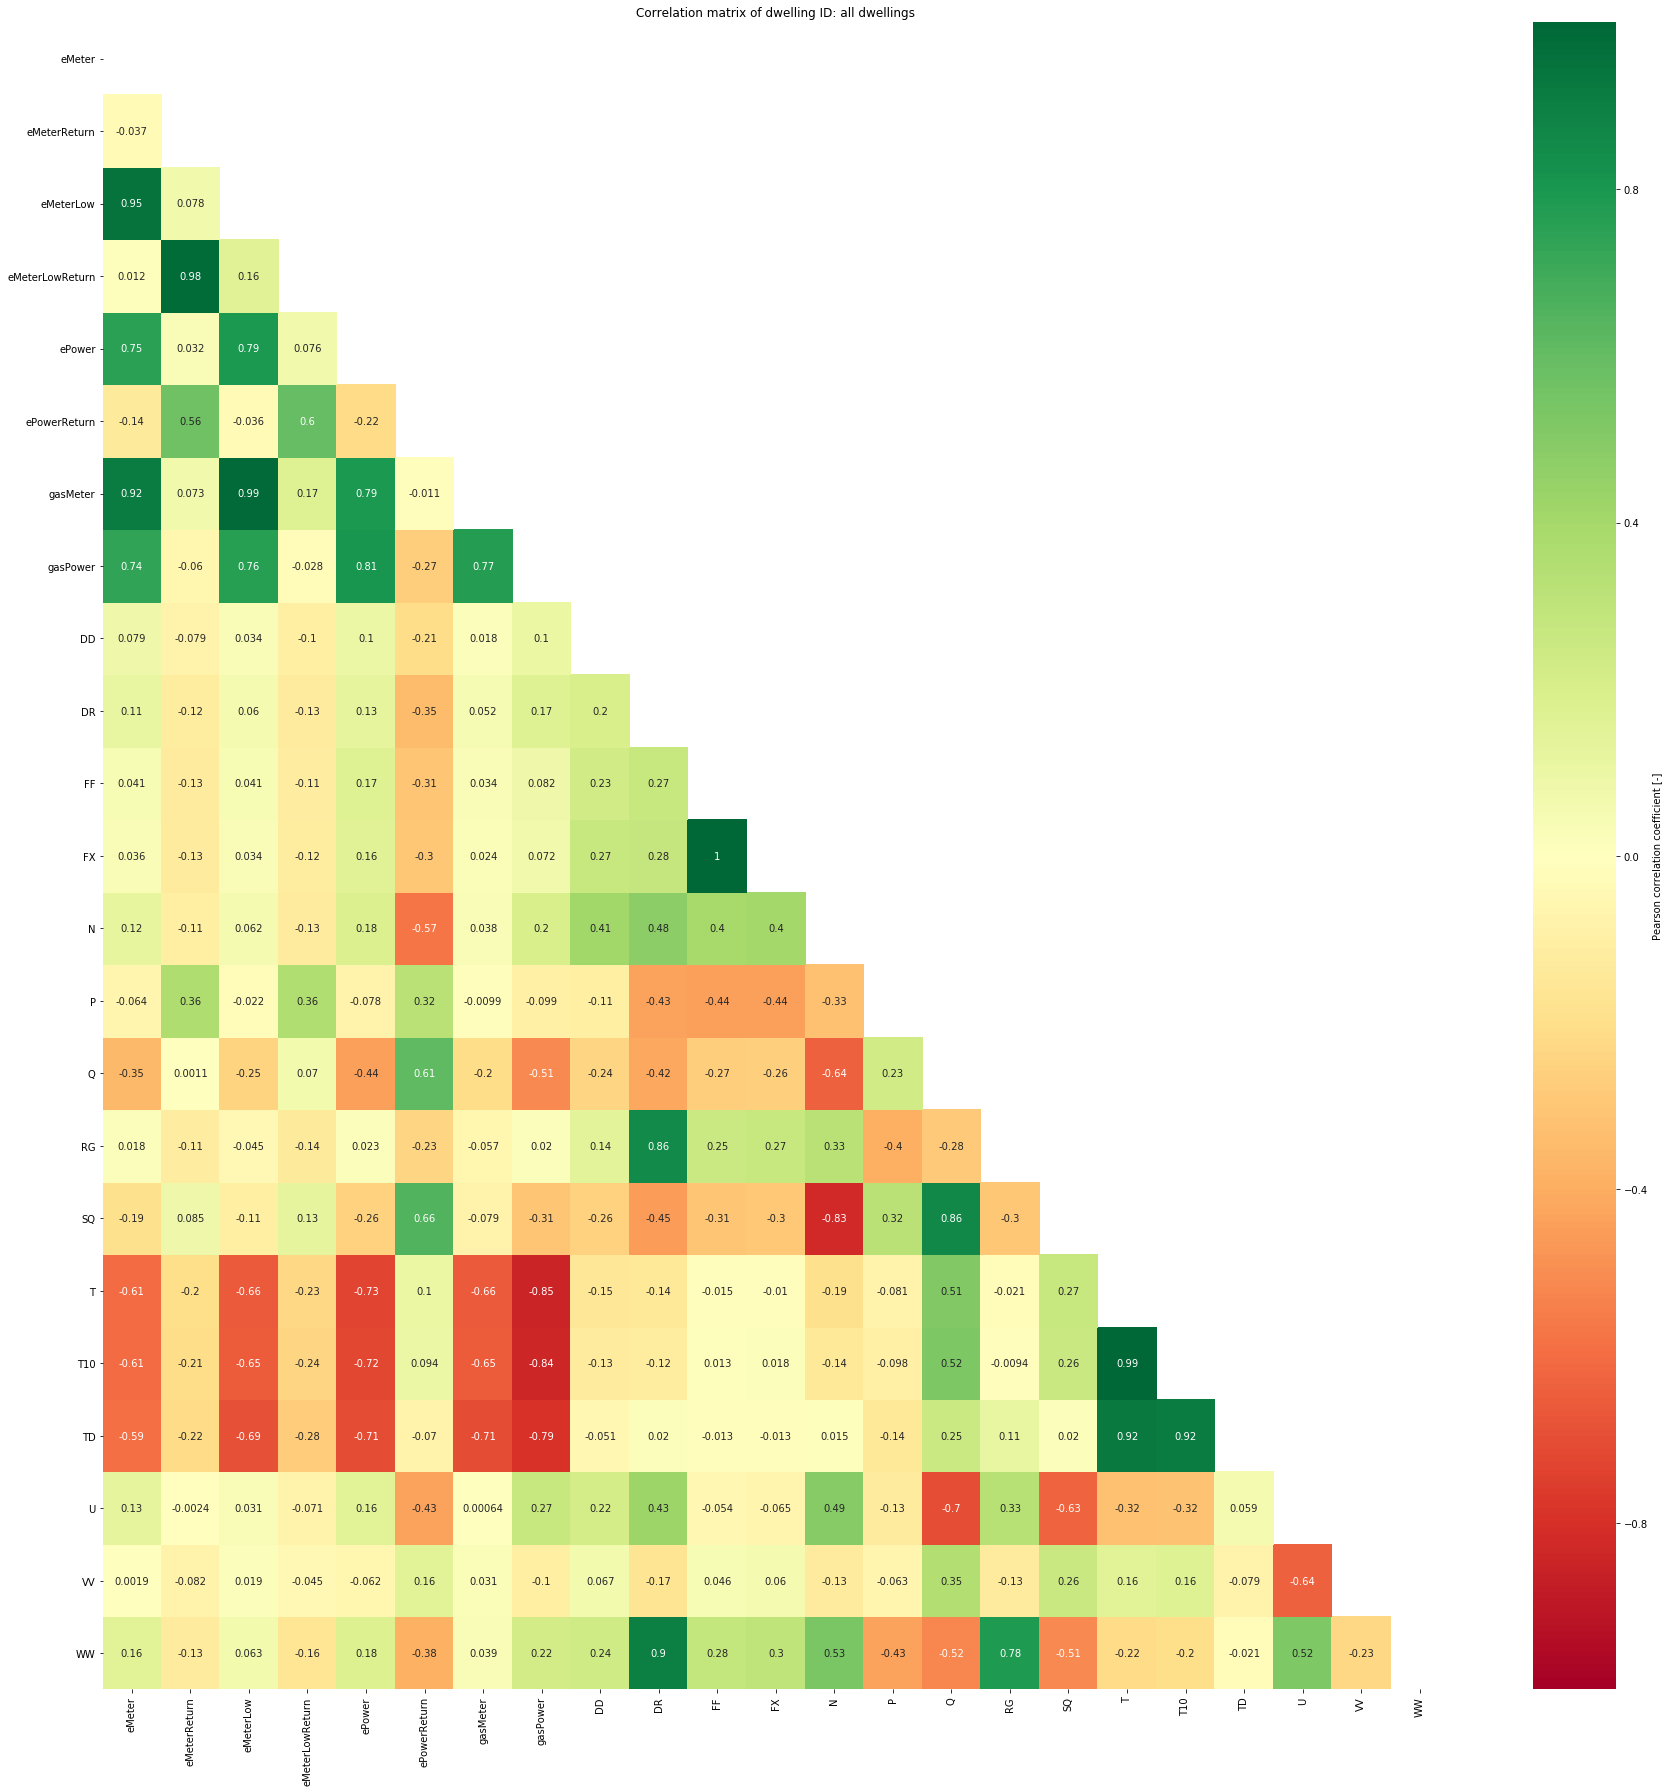

In [12]:
%%time
fig = create_corr_matrix(day, 'all dwellings', True)

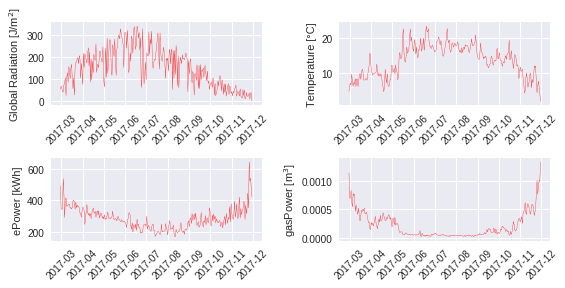

In [13]:
sns.set()

def datetime_layout():
    plt.xticks(rotation=45)
    #plt.grid()
    plt.tight_layout()

x = day.index

plt.subplot(3,2,1)
plt.plot(x, day['Q'], '-', color='r', linewidth=0.3)
#plt.xlabel('Date [-]')
plt.ylabel('Global Radiation [J/m$^2$]')
datetime_layout()

plt.subplot(3,2,2)
plt.plot(x, day['T'], '-', color='r', linewidth=0.3)
#plt.xlabel('Date [-]')
plt.ylabel('Temperature [°C]')
datetime_layout()

plt.subplot(3,2,3)
plt.plot(x, day['ePower'], '-', color='r', linewidth=0.3)
#plt.xlabel('Date [-]')
plt.ylabel('ePower [kWh]')
datetime_layout()

plt.subplot(3,2,4)
plt.plot(x, day['gasPower'], '-', color='r', linewidth=0.3)
#plt.xlabel('Date [-]')
plt.ylabel('gasPower [m$^3$]')
datetime_layout()

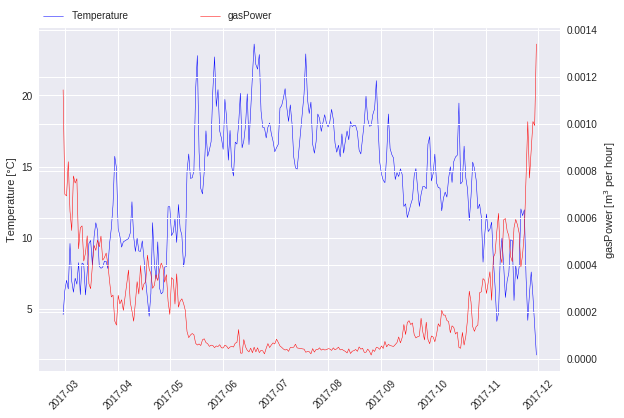

In [14]:
fig, ax = plt.subplots()
datetime_layout()

ax.plot(x, day['T'], 'b-', linewidth=0.5, label='Temperature')
ax.set_ylabel('Temperature [°C]')
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), borderaxespad=0, frameon=False) # Put legend on custom location
# more legend info: https://jdhao.github.io/2018/01/23/matplotlib-legend-outside-of-axes/

ax = ax.twinx() 
ax.plot(x, day.gasPower, 'r-', linewidth=0.5, label='gasPower')
ax.set_ylabel('gasPower [m$^3$ per hour]')

ax.legend(loc='lower left', bbox_to_anchor= (0.3, 1.01), borderaxespad=0, frameon=False)

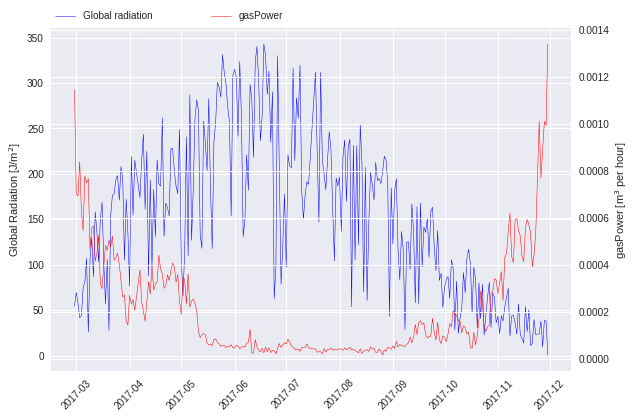

In [15]:
fig, ax = plt.subplots()
datetime_layout()

ax.plot(x, day['Q'], 'b-', linewidth=0.5, label='Global radiation')
ax.set_ylabel('Global Radiation [J/m$^2$]')
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), borderaxespad=0, frameon=False) # Put legend on custom location
# more legend info: https://jdhao.github.io/2018/01/23/matplotlib-legend-outside-of-axes/

ax = ax.twinx() 
ax.plot(x, day.gasPower, 'r-', linewidth=0.5, label='gasPower')
ax.set_ylabel('gasPower [m$^3$ per hour]')

ax.legend(loc='lower left', bbox_to_anchor= (0.3, 1.01), borderaxespad=0, frameon=False)

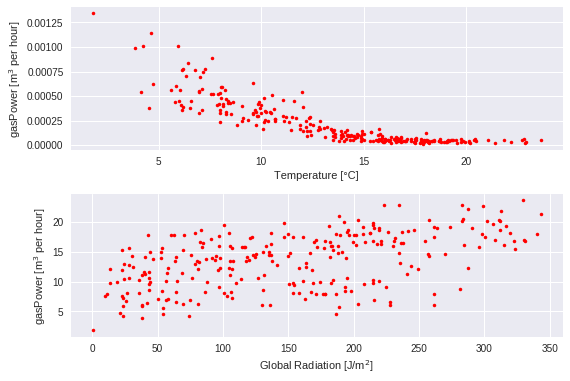

In [16]:
plt.subplot(2,1,1)
plt.plot(day['T'], day['gasPower'], '.', color='r', linewidth=0.3)
plt.ylabel('gasPower [m$^3$ per hour]')
plt.xlabel('Temperature [°C]')
plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(day['Q'], day['T'], '.', color='r', linewidth=0.3)
plt.ylabel('gasPower [m$^3$ per hour]')
plt.xlabel('Global Radiation [J/m$^2$]')
plt.tight_layout()

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1.23,'1 Day mean of all dwellings')

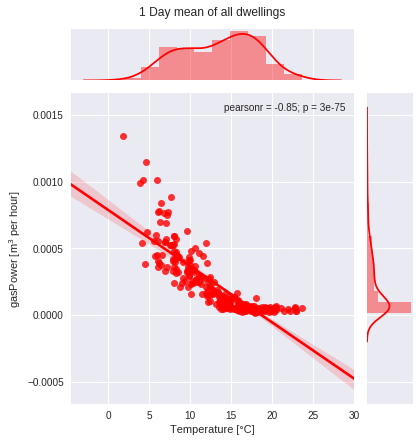

In [17]:
fig = sns.jointplot(x="T", y="gasPower", data=day, kind="reg", color='r')
sns.plt.ylabel('gasPower [m$^3$ per hour]')
sns.plt.xlabel('Temperature [°C]')
sns.plt.tight_layout()
sns.plt.title('1 Day mean of all dwellings', y=1.23)

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1.23,'1 Day mean of all dwellings')

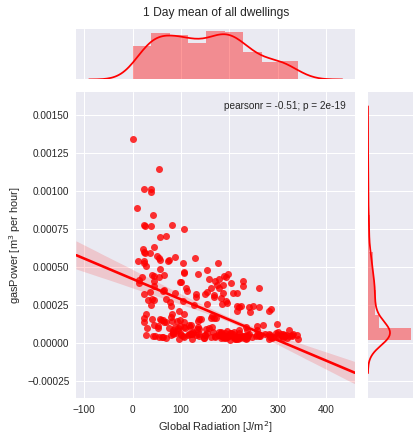

In [18]:
fig = sns.jointplot(x="Q", y="gasPower", data=day, kind="reg", color='r')
sns.plt.ylabel('gasPower [m$^3$ per hour]')
sns.plt.xlabel('Global Radiation [J/m$^2$]')
sns.plt.tight_layout()
sns.plt.title('1 Day mean of all dwellings', y=1.23)

Text(0.5,0,'gasPower')

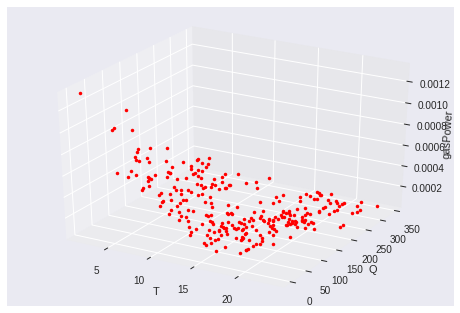

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(day['T'], day['Q'], day['gasPower'], '.', color='r')

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

Text(0.5,0,'gasPower')

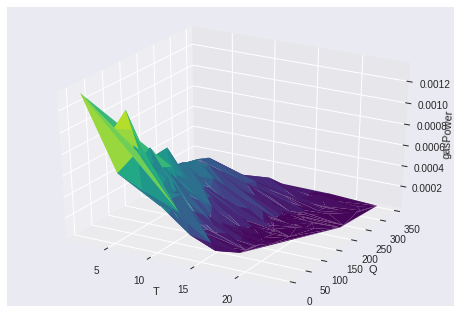

In [20]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(day['T'], day['Q'], day['gasPower'], cmap=plt.cm.viridis, linewidth=0.2, antialiased=True)

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

# Multivariable linear regression

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Nobody turns on their heating when T > 23, so drop this data
filtered = day[day['T'] < 22]



#X = filtered.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
X = filtered[['T', 'Q']]
#print('X columns: %s' % list(X.columns))
y = filtered['gasPower']

X = np.array(X).reshape(-1,2) # Reshape because sklearn wants you to
y = np.array(y).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.74570617170190423

Text(0.5,0,'gasPower')

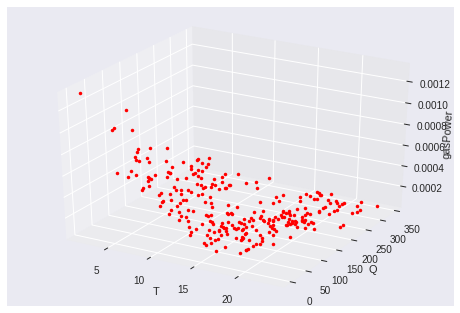

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(day['T'], day['Q'], day['gasPower'], '.', color='r')

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

Text(0.5,0,'gasPower')

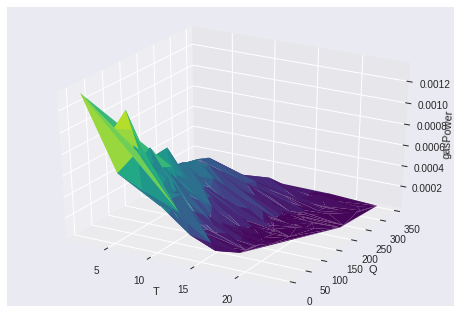

In [27]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(day['T'], day['Q'], day['gasPower'], cmap=plt.cm.viridis, linewidth=0.2, antialiased=True)

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

# Multivariable linear regression

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Nobody turns on their heating when T > 23, so drop this data
#filtered = day[day['T'] < 22]

X = filtered[['Q', 'T']]
print('X columns: %s' % list(X.columns))
y = filtered['gasPower']

X = np.array(X).reshape(-1,len(X.columns)) # Reshape because sklearn wants you to
y = np.array(y).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

X columns: ['Q', 'T']


0.74093394145887059

# Multivariable linear regression, more variables

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Nobody turns on their heating when T > 23, so drop this data
#filtered = day[day['T'] < 22]

X = filtered.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
print('X columns: %s' % list(X.columns))
y = filtered['gasPower']

X = np.array(X).reshape(-1,len(X.columns)) # Reshape because sklearn wants you to
y = np.array(y).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

X columns: ['ePower', 'ePowerReturn', 'gasPower', 'DD', 'FF', 'N', 'Q', 'RG', 'T', 'U']


0.99955690002985764